<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install genice to generate the structure of ice.
! pip install genice2

## benchmark test

In [2]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time


# sampling parameters for benchmarking
# Accurate
maxRepeat = 100  # loops
maxAccum  = 25   # sec
maxProc   = 100  # sec

# Rough
# maxRepeat = 10  # loops
# maxAccum  = 5   # sec
# maxProc   = 10  # sec

In [14]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [ ]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)

lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,)) # generates an undirected graph
water      = Molecule("spce")
            
buch = []
lastN = 0
for NN in range(8,100):
    N = int(1.4**(NN/3))
    if N == lastN:
        continue
    lastN = N
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < maxAccum and Nrep < maxRepeat:
        dd = nx.DiGraph()
        for a,b in g.edges():
            if random.randint(0,1) == 1:
                dd.add_edge(a,b)
            else:
                dd.add_edge(b,a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if dd.out_degree(x)>2]))
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    buch.append([Nnode,delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > maxProc:
        break

## GenIce algorithm

Tiling by cycles.

In [ ]:
from collections import defaultdict

def find_cycle(g, chain, order):
    head = chain[-1]
    last = -1
    if len(chain) > 1:
        last = chain[-2]
    while True:
        nexts = [i for i in g[head] if i != last]
        last = head
        head = random.choice(nexts)
        i = order[head]
        if i == 0:
            # returns to the first node of the chain
            order[head] = -1
            return [], chain
        elif i > 0:
            # crosses at an intermediate node of the chain
            return chain[:i+1], chain[i:]
        order[head] = len(chain)
        chain.append(head)

        
def remove_cycle(g, cycle, order):
    for i in range(1,len(cycle)):
        order[cycle[i]] = -1
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a,b)
    for a in cycle:
        if g.degree(a) == 0:
            g.remove_node(a)


def tileByCycles(g):
    chain = []
    order = -np.ones(g.number_of_nodes(), dtype=np.int)
    while g.number_of_nodes() > 0:
        if len(chain) == 0:
            head  = random.choice(list(g.nodes()))
            chain = [head]
            # "order" stores the order of a node in the chain
            order[head] = 0
        chain, cycle = find_cycle(g, chain, order)
        yield cycle
#         print(chain, cycle, order, "before removal")
        remove_cycle(g, cycle, order)
#         print(chain, cycle, order)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(2,)) # generates an undirected graph
water      = Molecule("spce")

gen  = []
for NN in range(4,100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    # 一旦無向グラフになおし、

    delta = 0.0
    Nrep  = 0
    while delta < maxAccum and Nrep < maxRepeat:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            if random.randint(0,1) == 0:
                nx.add_cycle(dd, cycle)
            else:
                nx.add_cycle(dd, cycle[::-1])
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    gen.append([Nnode,delta,Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= 1e6:
        break

## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [ ]:
import random

def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next

def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a,b)
        d.add_edge(b,a)
        # footprint
        if g.has_edge(a,b):
            g.remove_edge(a,b)


lattice    = Lattice("1c") 
formatter  = Format("raw", stage=(3,)) # We need the directed graph of ice!
water      = Molecule("spce")

rahman  = []
for N in range(1,20):
    raw = GenIce(lattice, rep=[N,N,N]).generate_ice(water, formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep  = 0
    while delta < maxAccum and Nrep < maxRepeat:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep  += 1
    delta /= Nrep
    rahman.append([Nnode,delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > maxProc:
        break


Text(0, 0.5, 'Time / s')

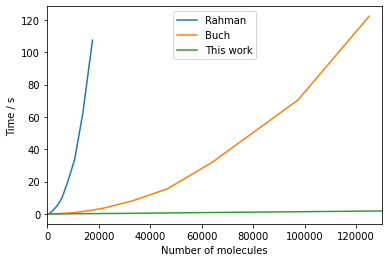

In [ ]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen  = np.array(gen)
rahman = np.array(rahman)

plt.plot(rahman[:,0], rahman[:,1], label="Rahman")
plt.plot(buch[:,0], buch[:,1], label="Buch")
plt.plot(gen[:,0], gen[:,1], label="This work")
plt.xlim(0,130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")



Text(0, 0.5, 'Time / s')

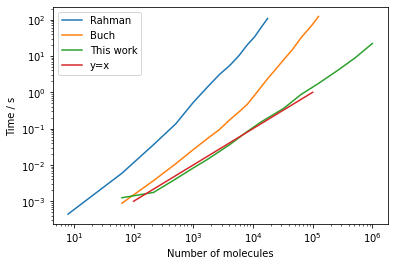

In [ ]:
lin = np.linspace(1e2, 1e5,100)
plt.loglog(rahman[:,0], rahman[:,1], label="Rahman")
plt.loglog(buch[:,0], buch[:,1], label="Buch")
plt.loglog(gen[:,0], gen[:,1], label="This work")
plt.loglog(lin, lin*1e-5, label="y=x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")


128


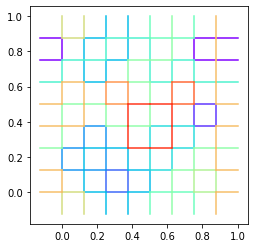

In [51]:
# for TOC graphics

from matplotlib import pyplot as plt

# make a 2D 6x6 ice.

def draw_cycle(cycle, pos, N, col):
    threshold = 1.1/N**2
    cm = plt.get_cmap('rainbow')
    segs = []
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        va = pos[a]
        vb = pos[b]
        d = vb - va
        if d@d > threshold:
            d -= np.floor(d+0.5)
            seg = np.vstack([vb-d, vb])
            plt.plot(seg[:,0], seg[:,1], color=cm(col))
        seg = np.vstack([va, va+d])
        plt.plot(seg[:,0], seg[:,1], color=cm(col))

N = 8
X = np.arange(N)
Y = np.arange(N)
X,Y = np.meshgrid(X,Y)
X = X.reshape(N*N)
Y = Y.reshape(N*N)
pos = np.vstack([X,Y]).T / N # fractional coordinate
g = nx.Graph()
for a in range(N*N):
    for b in range(a):
        d = pos[a] - pos[b]
        d -= np.floor(d+0.5)
        if (d@d)*N*N < 1.1:
            g.add_edge(a,b)

print(g.number_of_edges())


fig1, ax = plt.subplots()

cycles = []
dd = nx.DiGraph()
for cycle in tileByCycles(g):
    cycles.append(cycle)

for i, cycle in enumerate(cycles):
    draw_cycle(cycle, pos, N, i/len(cycles))

ax.set_aspect('equal', adjustable='box')
plt.show()
fig1.savefig("map.pdf", bbox='tight')